In [89]:
#HAHA
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
import random
from sklearn.preprocessing import StandardScaler

# Make plots inline
%matplotlib inline

In [90]:
random.seed(666)

# 1 Read Data

In [91]:
#read the data and create data frame
df = pd.read_csv('heart_rate_data.csv')
df['time'] = np.linspace(0, 900, len(df))
df.columns = ['Y','time']
print(df.shape)
df.head(3)

(1799, 2)


,Y,time
0,84.2697,0.000000
1,84.0619,0.500556
2,85.6542,1.001112


In [92]:
#normalize Y
Y = df['Y'].to_numpy().reshape(-1, 1)
transformer = StandardScaler().fit(Y)
df['Y'] = transformer.transform(Y)
print(df.shape)
df.head(3)

(1799, 2)


,Y,time
0,-1.518649,0.000000
1,-1.556528,0.500556
2,-1.266271,1.001112


In [93]:
from sklearn.model_selection import train_test_split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(df['time'][:600], df['Y'][:600], test_size = 0.3, random_state= 66)
X_train_, Y_train_, X_test_, Y_test_ = X_train_.sort_index(), Y_train_.sort_index(), X_test_.sort_index(), Y_test_.sort_index()
X_train_, Y_train_, X_test_, Y_test_  = np.array(X_train_), np.array(Y_train_), np.array(X_test_), np.array(Y_test_)
X_train, Y_train, X_test, Y_test = torch.tensor(X_train_), torch.tensor(Y_train_), torch.tensor(X_test_), torch.tensor(Y_test_)
X_all_linspace = np.arange(0, float(df['time'][600]), 0.5)
X_all_linspace = torch.tensor(X_all_linspace)

# 2 Implement Model with GpyTorch

## Settings for Experiment

'Model 1.1.1: RBF'

'Model 1.1.2: RBF + Fixed Noise Likelihood'

'Model 1.2.1: RBF + SKI'

'Model 1.2.2: RBF + SKI + Fixed Noise Likelihood'

'Model 2.1.1: Periodic'

'Model 2.1.2: Periodic + Fixed Noise Likelihood'

'Model 2.2.1: Periodic + SKI'

'Model 2.2.2: Periodic + SKI + Fixed Noise Likelihood'

'Model 3.1.1: Periodic + RBF'

'Model 3.1.2: Periodic + RBF + Fixed Noise Likelihood'

'Model 3.2.1: Periodic + RBF + SKI'

'Model 3.2.2: Periodic + RBF + SKI + Fixed Noise Likelihood'

Deep Model-----------

In [94]:
#we have 3 * 2 * 2 = 12 experiment in our first set
model_name_list = [[['Model 1.1.1: RBF', 'Model 1.1.2: RBF + Fixed Noise Likelihood'], ['Model 1.2.1: RBF + SKI', 'Model 1.2.2: RBF + SKI + Fixed Noise Likelihood']],\
        [['Model 2.1.1: Periodic', 'Model 2.1.2: Periodic + Fixed Noise Likelihood'], ['Model 2.2.1: Periodic + SKI', 'Model 2.2.2: Periodic + SKI + Fixed Noise Likelihood']], \
        [['Model 3.1.1: Periodic + RBF', 'Model 3.1.2: Periodic + RBF + Fixed Noise Likelihood'], ['Model 3.2.1: Periodic + RBF + SKI', 'Model 3.2.2: Periodic + RBF + SKI + Fixed Noise Likelihood']]]

In [95]:
kernel_list = [gpytorch.kernels.RBFKernel(), gpytorch.kernels.PeriodicKernel(), gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel()]

In [96]:
def plot_loss_in_training_process(experiment_index, train_losses_mll, test_losses_mse, test_losses_msll):
    #plot loss log
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(model_name_list[experiment_index[0]][experiment_index[1]][experiment_index[2]] + ' Loss w.r.t Training Epoch')
    axs[0].plot(train_losses_mll, label = 'Training Loss MLL')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Loss (MLL)')
    axs[0].set_title('Training Error')
    axs[0].legend()

    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Loss (MSE)')
    axs[1].plot(test_losses_mse, label = 'Testing Loss MSE', c = 'orange')
    axs[1].set_title('testing error')
    axs[1].legend()

    axs[2].set_xlabel('Iterations')
    axs[2].set_ylabel('Loss (MSLL)')
    axs[2].plot(test_losses_msll, label = 'Testing Loss MSLL', c = 'purple')
    axs[2].set_title('Testing Error')
    axs[2].legend()

In [97]:
def plot_predicting_result(model, likelihood, experiment_index):
    model.eval()
    likelihood.eval()
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        all_prediction = likelihood(model(X_all_linspace))
        all_mean = all_prediction.mean
        all_lower, all_upper = all_prediction.confidence_region()

    plt.figure(figsize=(12,8))
    plt.plot(X_train, Y_train, 'y.', markersize=10, label='Training Data') #plot training data
    plt.plot(X_test, Y_test, 'bx', markersize=6, label='Testing Data') #plot testing data
    
    plt.plot(X_all_linspace, all_mean, 'g-', label='Posterier Mean') # plot training prediction
    
    plt.fill_between(X_all_linspace, all_lower, all_upper, alpha=0.5, label = 'Posterior CI') #add CI

    plt.title(model_name_list[experiment_index[0]][experiment_index[1]][experiment_index[2]] +  ' Interpolation Result Analysis')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend(loc='upper left')
    plt.show()

In [98]:
def training(model, likelihood, optimizer, mll, training_iterations = 300):
    start_time = time.time()
    train_losses_mll = []
    test_losses_mse = []
    test_losses_msll = []
    time_list = []

    for epoch in range(training_iterations):
        #get train loss for this iter
        model.train()
        likelihood.train()
        optimizer.zero_grad()
        train_predition = model(X_train)
        train_loss = -mll(train_predition, Y_train)        
        train_losses_mll.append(train_loss)
        time_list.append(time.time() - start_time)
        train_loss.backward()
        optimizer.step()

        #get test loss for this iter
        model.eval()
        with torch.no_grad():
            trained_pred_dist = likelihood(model(X_test))
            predictive_mean = trained_pred_dist.mean
            lower, upper = trained_pred_dist.confidence_region()
            #here we use mse instead of marginal log likelihood because 
            #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
            test_msll = gpytorch.metrics.mean_standardized_log_loss(trained_pred_dist, Y_test)
            test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
            test_losses_mse.append(test_mse)
            test_losses_msll.append(test_msll)
    
    end_time = time.time()
    train_losses_mll = [float(i) for i in train_losses_mll]
    test_losses_mse = [float(i) for i in test_losses_mse]
    test_losses_msll = [float(i) for i in test_losses_msll]

    print('tesing MSE after', training_iterations, 'epochs:', test_losses_mse[-1])
    print('tesing MSLL after', training_iterations, 'epochs:', test_losses_msll[-1])
    print('training duration for', training_iterations, 'epochs:', end_time - start_time)

    return time_list, train_losses_mll, test_losses_mse, test_losses_msll, end_time - start_time
    

In [99]:
def GP_experiment(experiment_index):
    current_experiment_index = experiment_index
    #define the model
    class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, experiment_index):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            
            grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0) # SKI requires a grid size hyperparameter.
            #we are going to warpping below kernel inside the interpolation kernel
            self.base_kernel = gpytorch.kernels.RBFKernel()

            #Exp-Sine-Squared kernel (aka periodic kernel)

            self.mean_module = gpytorch.means.ConstantMean()
            
            if experiment_index[1] == 0: #without SKI
                self.covar_module = gpytorch.kernels.ScaleKernel(kernel_list[experiment_index[0]])
            else: #with SKI
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.GridInterpolationKernel(kernel_list[experiment_index[0]], grid_size=grid_size, num_dims=1))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    #training
    likelihood = gpytorch.likelihoods.GaussianLikelihood() if current_experiment_index[2] == 0 else FixedNoiseGaussianLikelihood(torch.ones(len(X_train))* 0.01, learn_additional_noise=True)
    model = GPRegressionModel(X_train, Y_train, likelihood, current_experiment_index)
    
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    return model, likelihood

### Model 1.1.1: RBF

tesing MSE after 300 epochs: 0.04447267065771108
tesing MSLL after 300 epochs: -0.4619118989229719
training duration for 300 epochs: 9.963629961013794


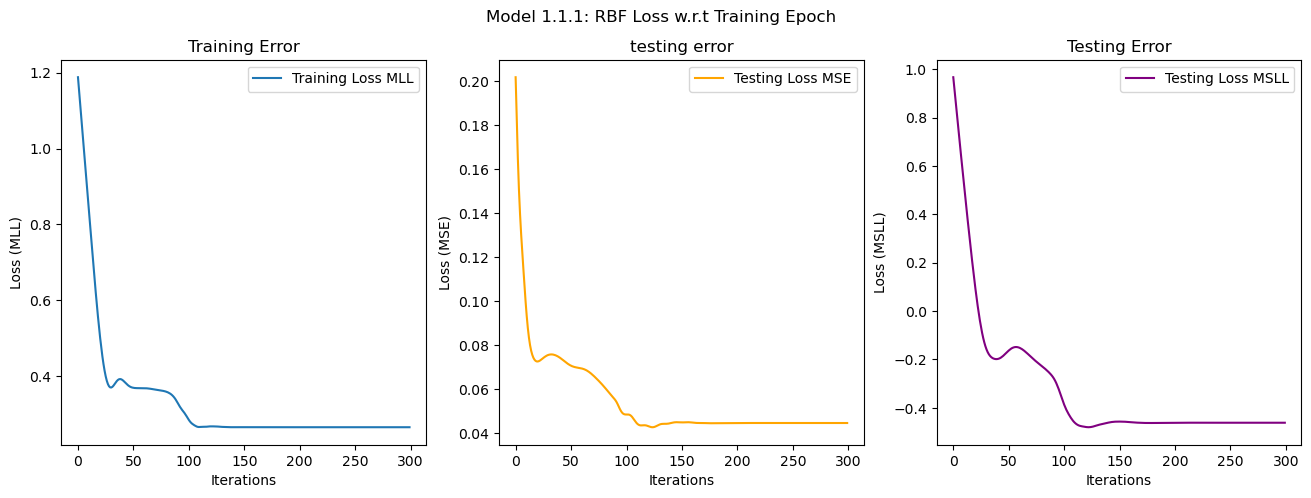

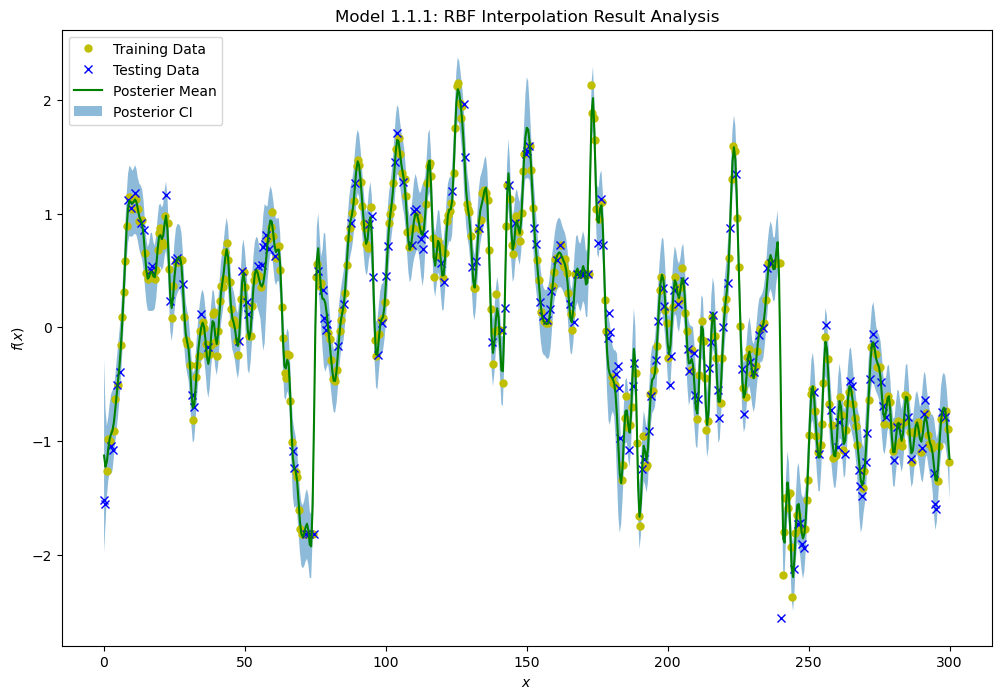

In [100]:
current_experiment_index = [0, 0, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 1.1.2: RBF + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.04452612085942066
tesing MSLL after 300 epochs: -0.42518370403953454
training duration for 300 epochs: 9.250635862350464


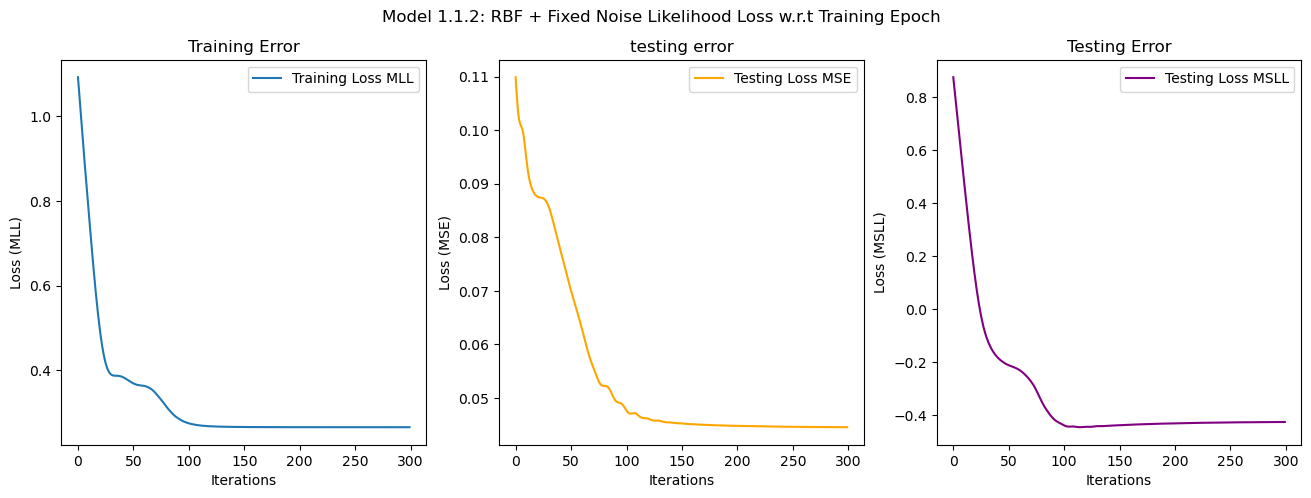

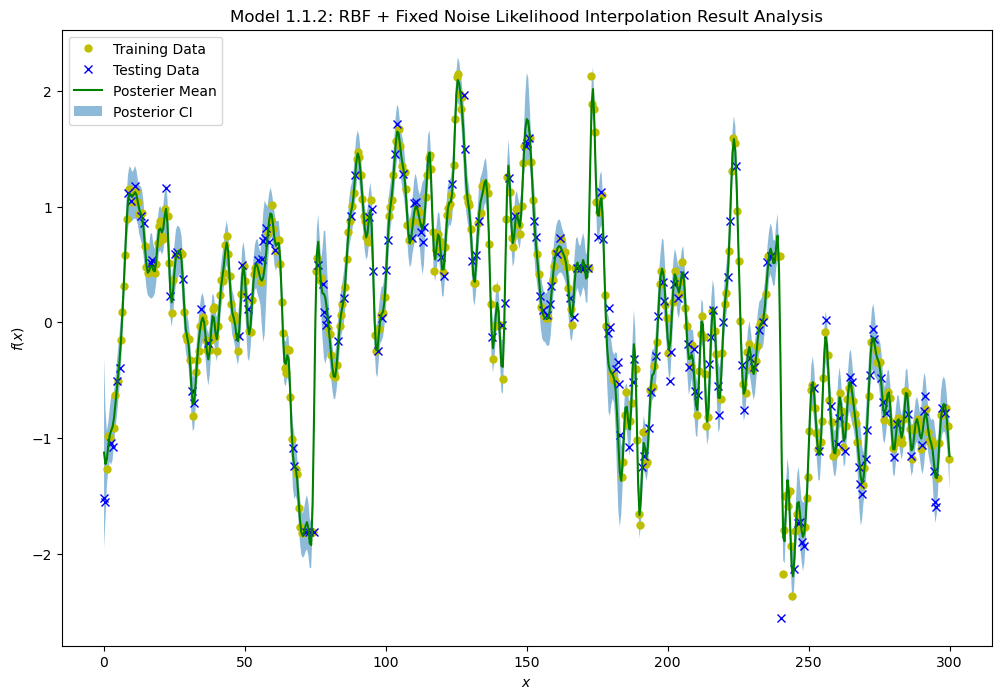

In [101]:
current_experiment_index = [0, 0, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list112, train_losses_mll112 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 1.2.1: RBF + SKI

tesing MSE after 300 epochs: 0.08980007422906237
tesing MSLL after 300 epochs: -0.0285244745528746
training duration for 300 epochs: 42.407487869262695


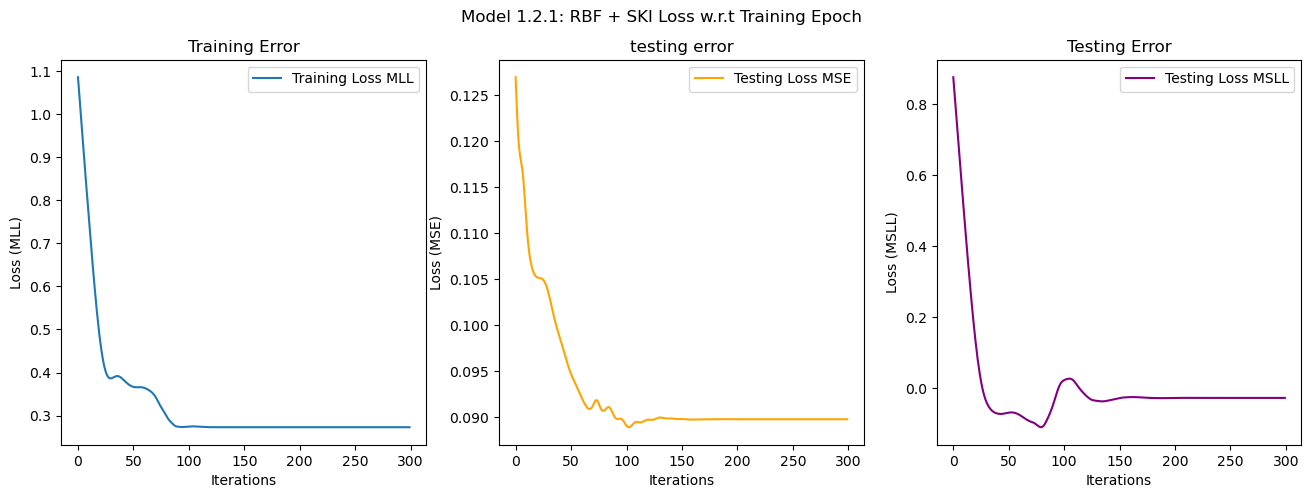

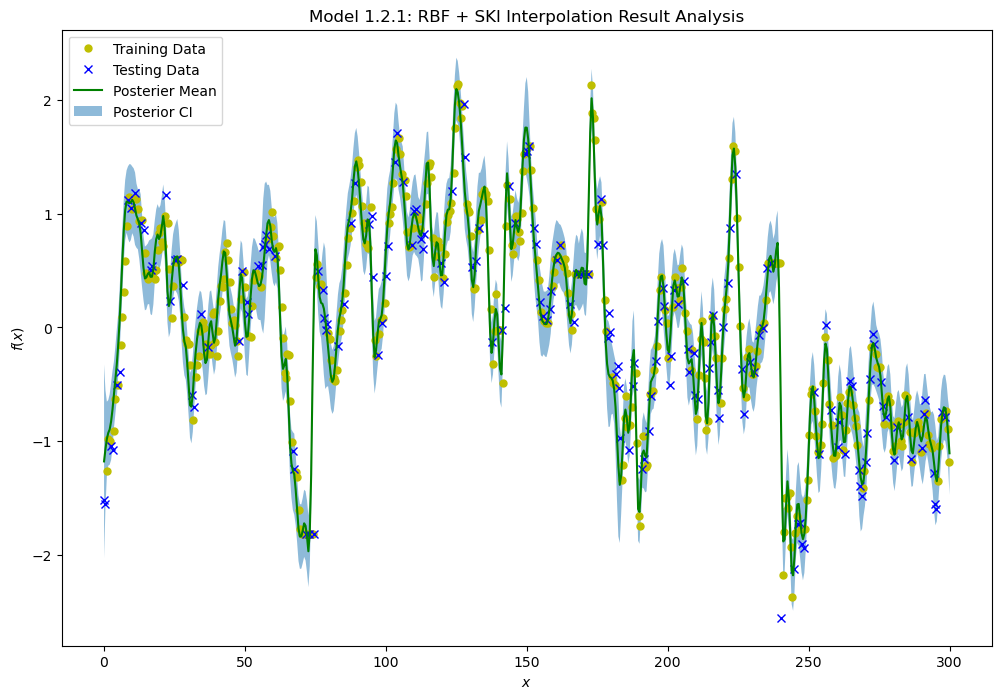

In [102]:
current_experiment_index = [0, 1, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 1.2.2: RBF + SKI + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.08980387735566796
tesing MSLL after 300 epochs: 0.3189139405429014
training duration for 300 epochs: 42.511852979660034


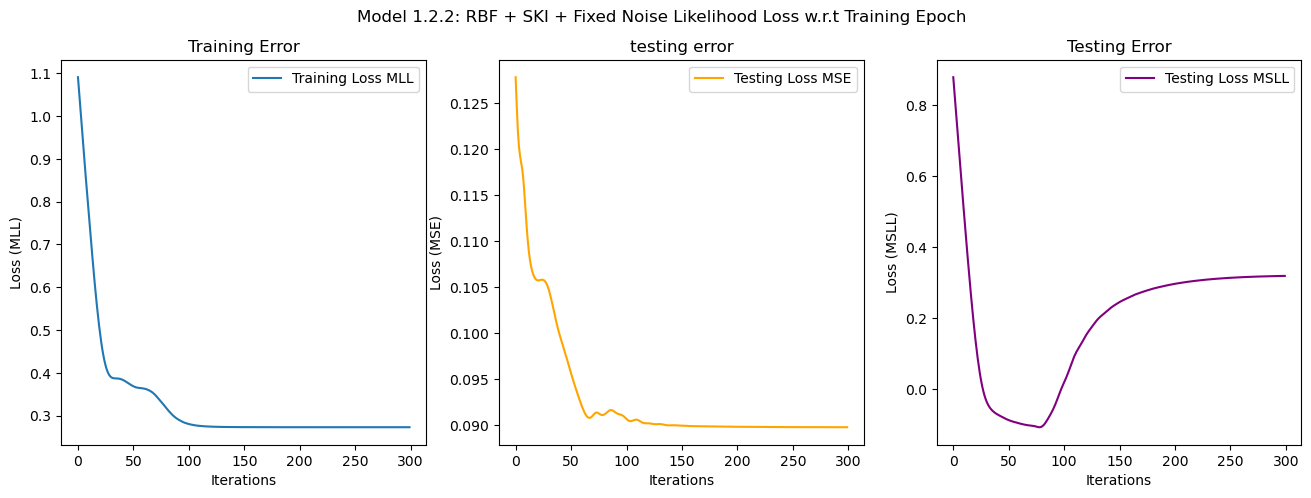

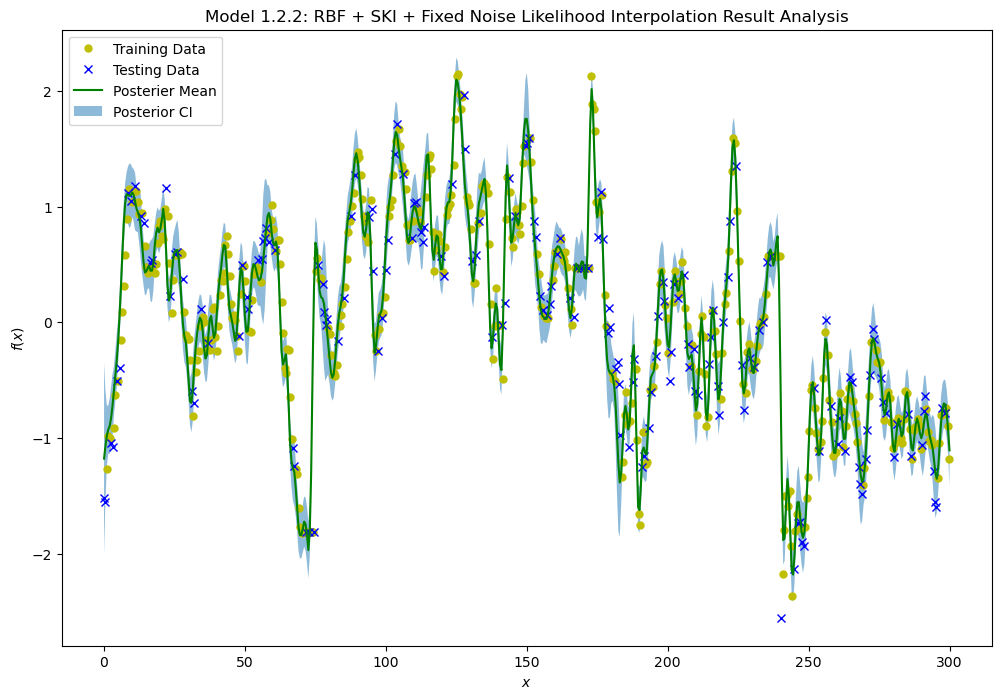

In [103]:
current_experiment_index = [0, 1, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list122, train_losses_mll122 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 2.1.1: Periodic

tesing MSE after 300 epochs: 0.7996963510615905
tesing MSLL after 300 epochs: 1.0535667728127165
training duration for 300 epochs: 14.175850868225098


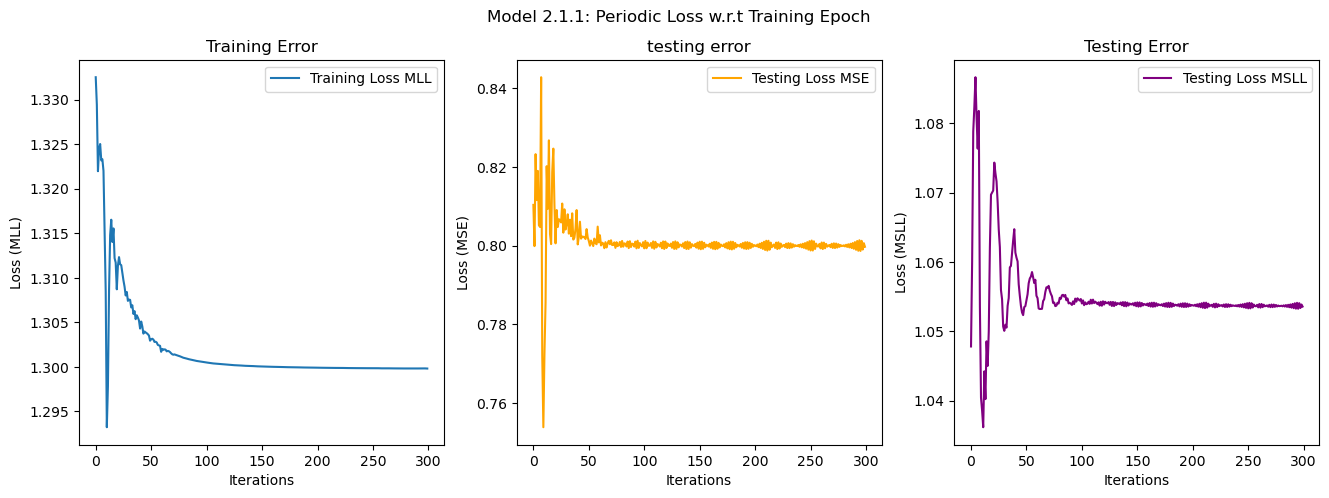

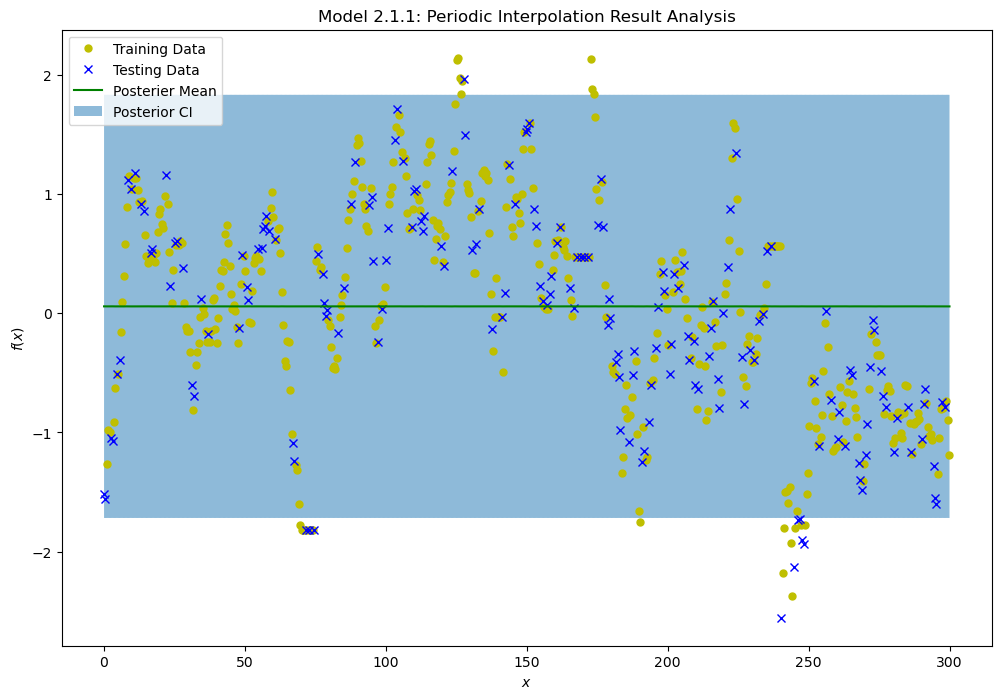

In [104]:
current_experiment_index = [1, 0, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 2.1.2: Periodic + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.8008174712419911
tesing MSLL after 300 epochs: 1.0507792359668988
training duration for 300 epochs: 14.033889055252075


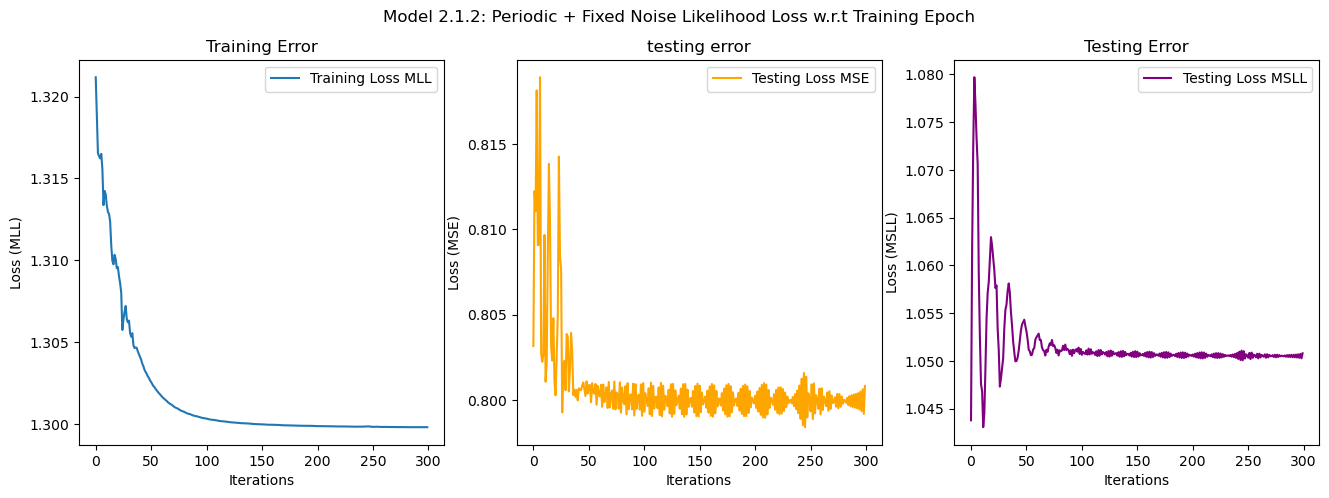

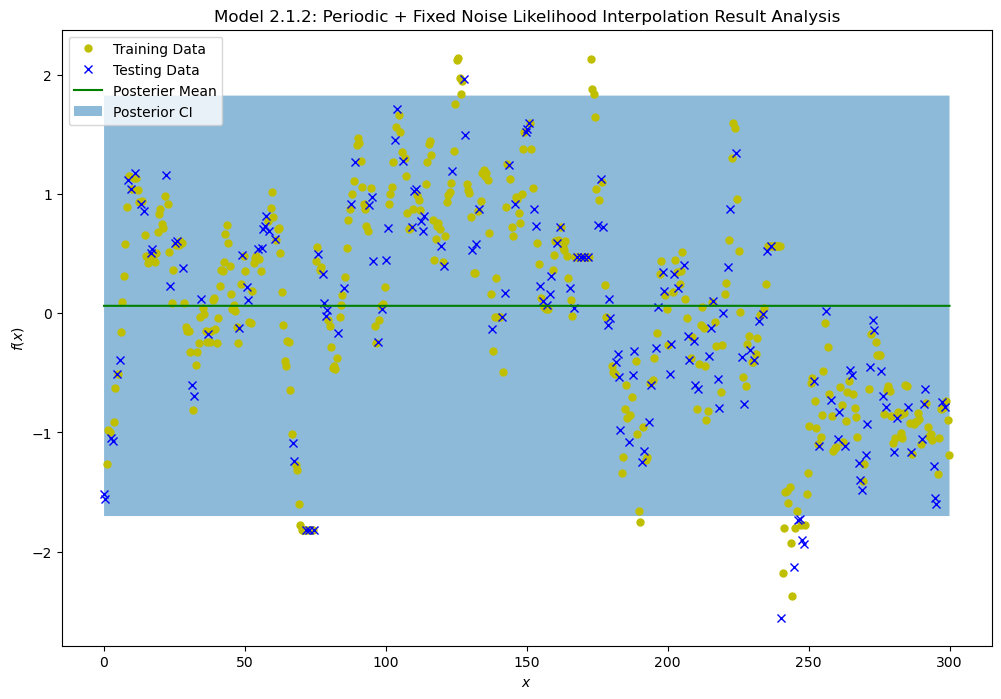

In [105]:
current_experiment_index = [1, 0, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list212, train_losses_mll212 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 2.2.1: Periodic + SKI

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


tesing MSE after 300 epochs: 0.8001712473121418
tesing MSLL after 300 epochs: 1.0536805459630885
training duration for 300 epochs: 42.477251052856445


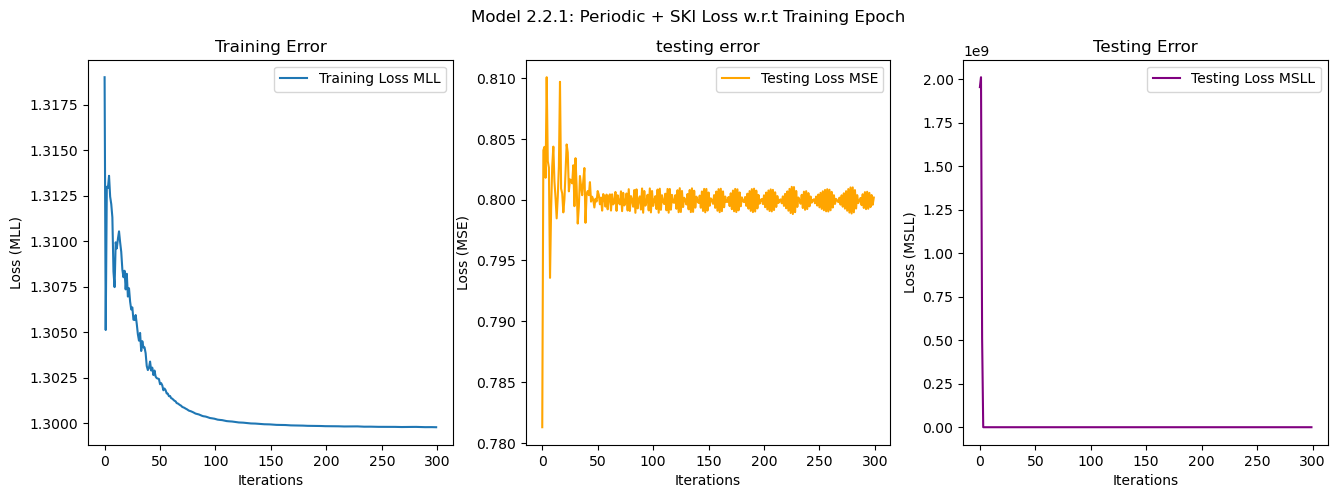

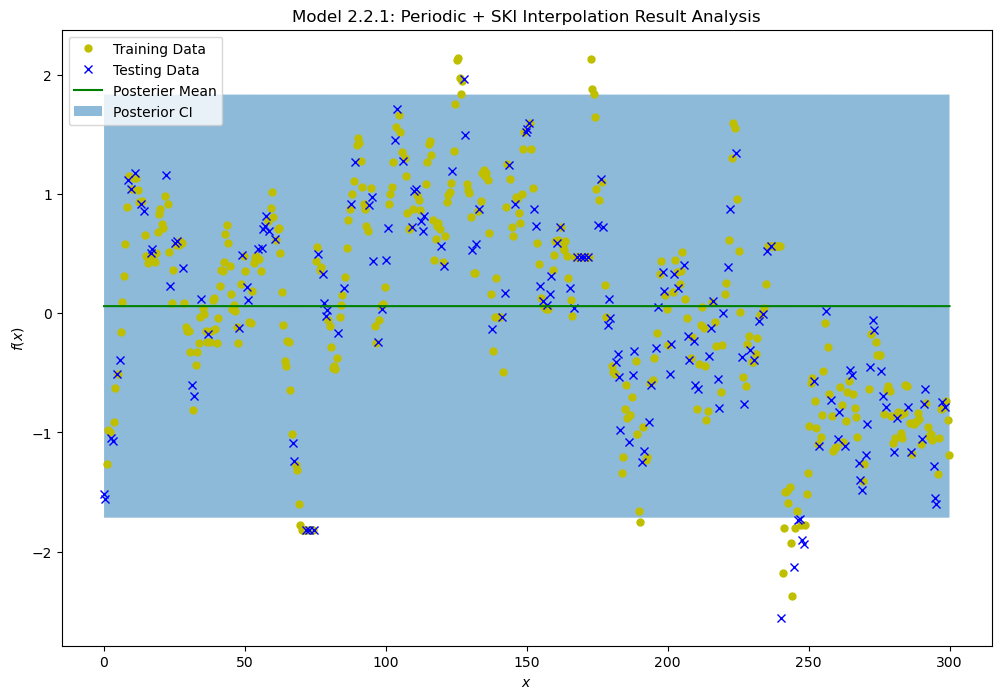

In [106]:
current_experiment_index = [1, 1, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 2.2.2: Periodic + SKI + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.7997398788457758
tesing MSLL after 300 epochs: 1.0504130433790377
training duration for 300 epochs: 43.136905908584595


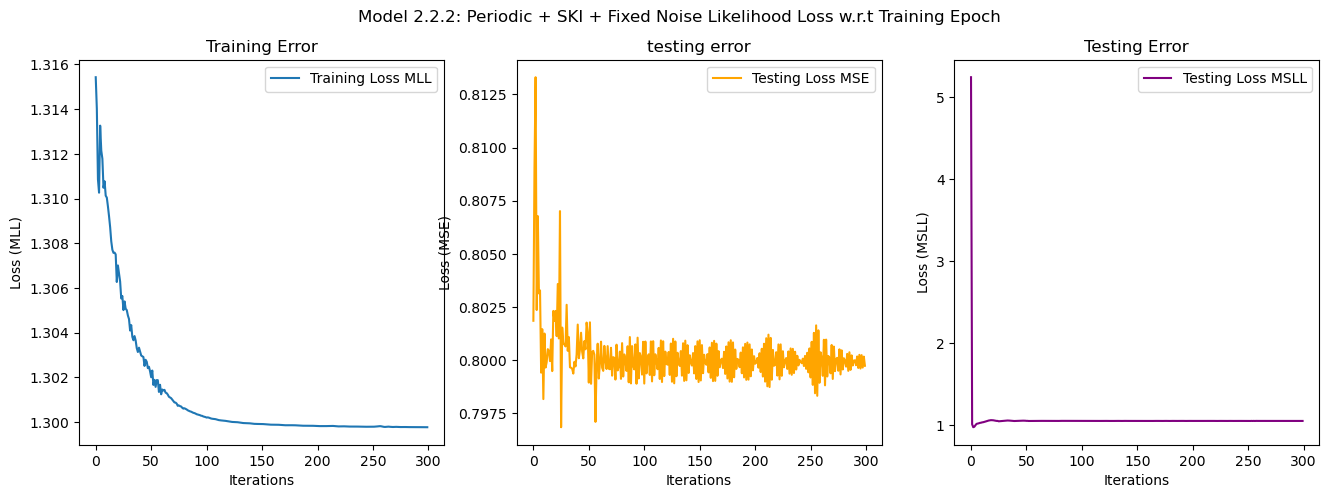

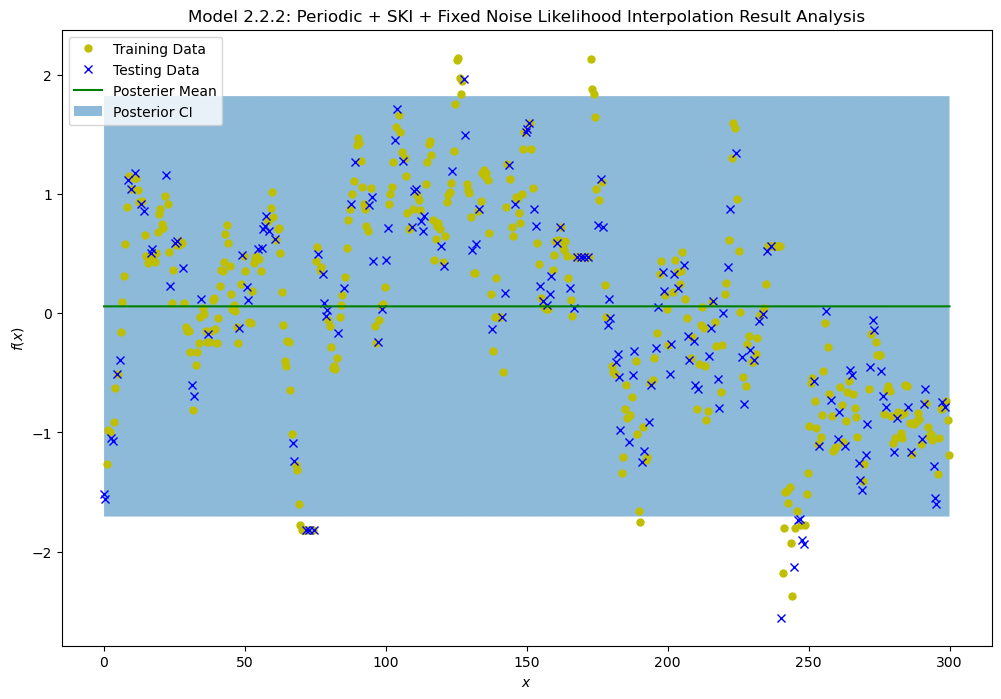

In [107]:
current_experiment_index = [1, 1, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list222, train_losses_mll222 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 3.1.1: Periodic + RBF

tesing MSE after 300 epochs: 0.04663720547019231
tesing MSLL after 300 epochs: -0.44279046569844493
training duration for 300 epochs: 17.54652714729309


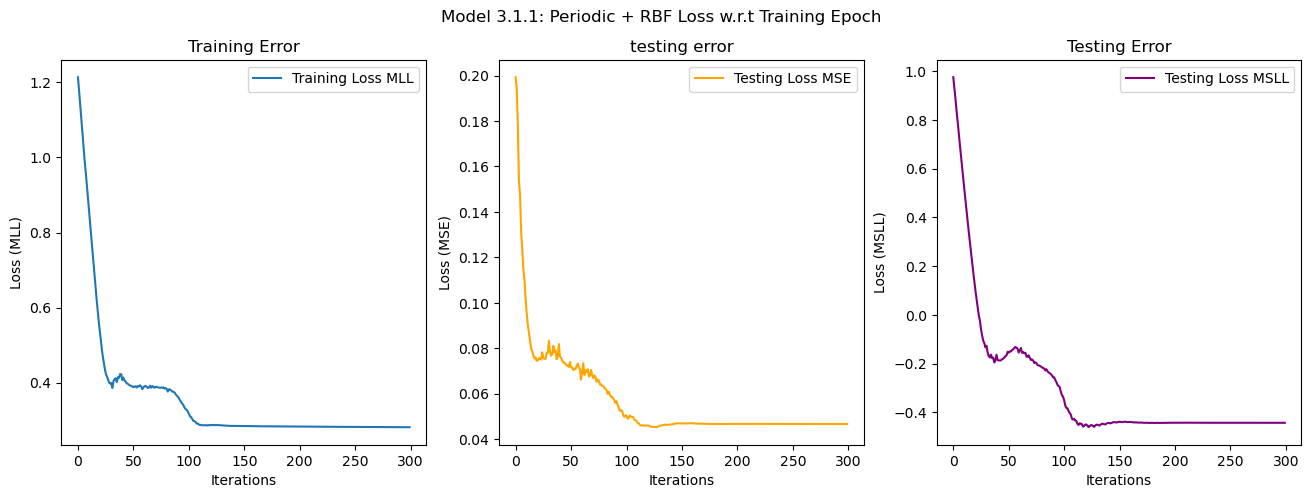

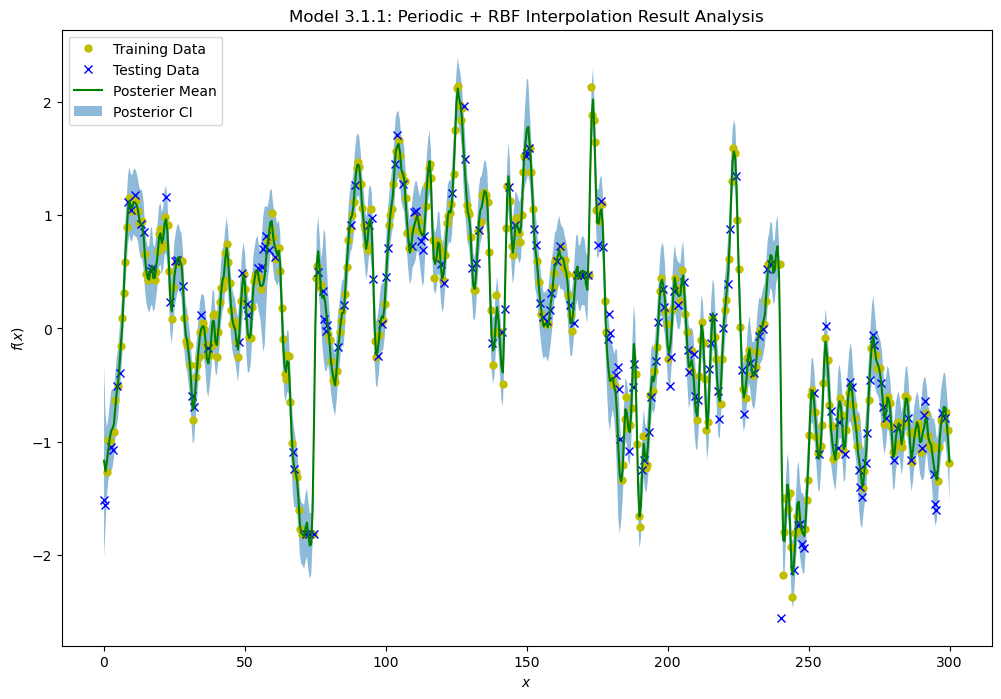

In [108]:
current_experiment_index = [2, 0, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 3.1.2: Periodic + RBF + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.04729723563015162
tesing MSLL after 300 epochs: -0.4061621526984715
training duration for 300 epochs: 16.309125900268555


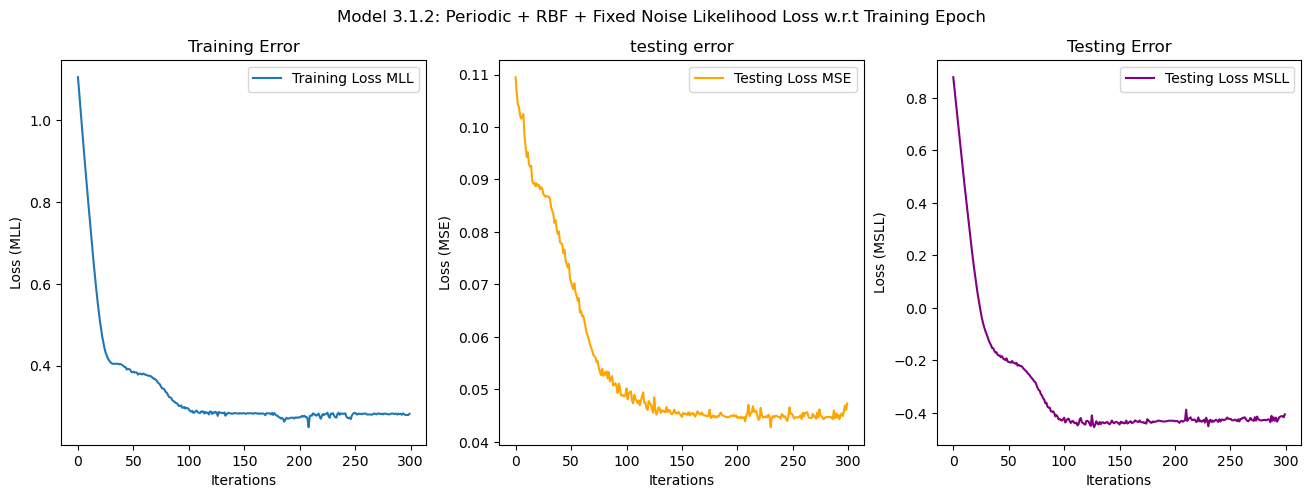

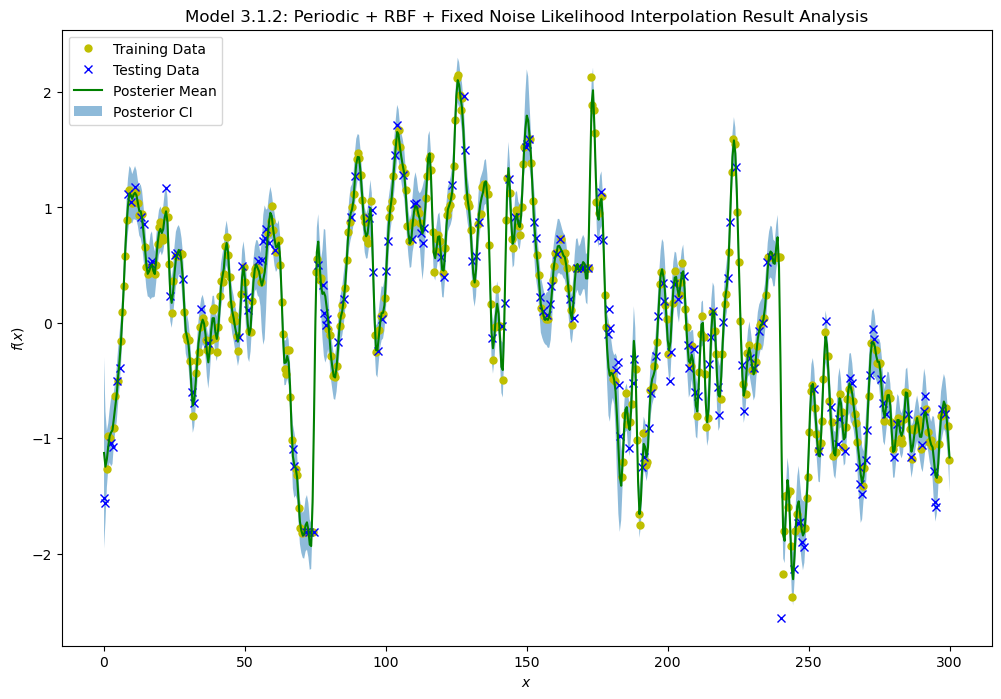

In [109]:
current_experiment_index = [2, 0, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list312, train_losses_mll312 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 3.2.1: Periodic + RBF + SKI

tesing MSE after 300 epochs: 0.08990850213219424
tesing MSLL after 300 epochs: 27602841.083496198
training duration for 300 epochs: 42.96745014190674


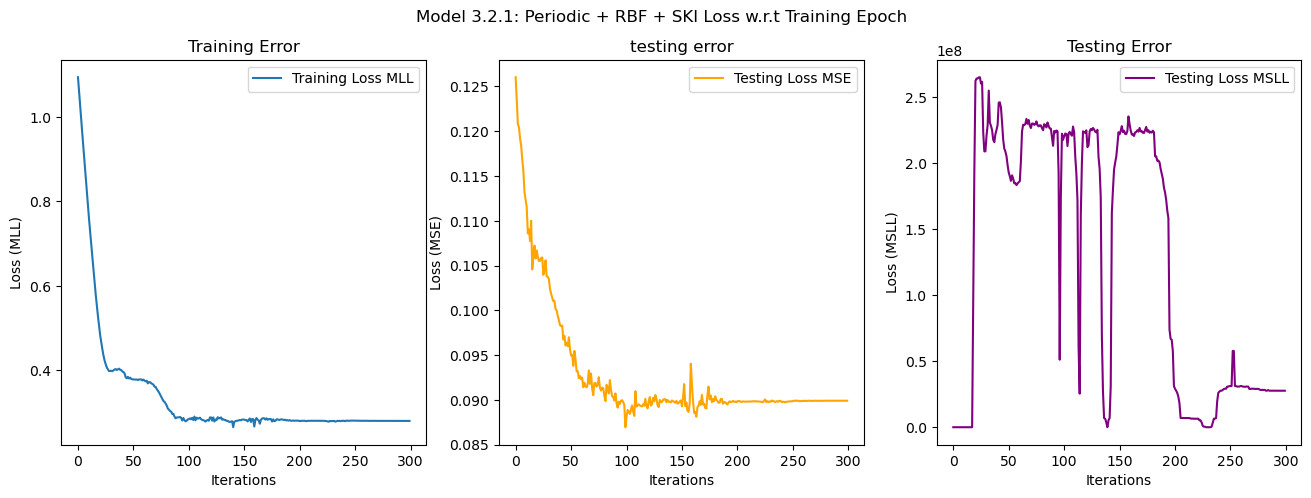

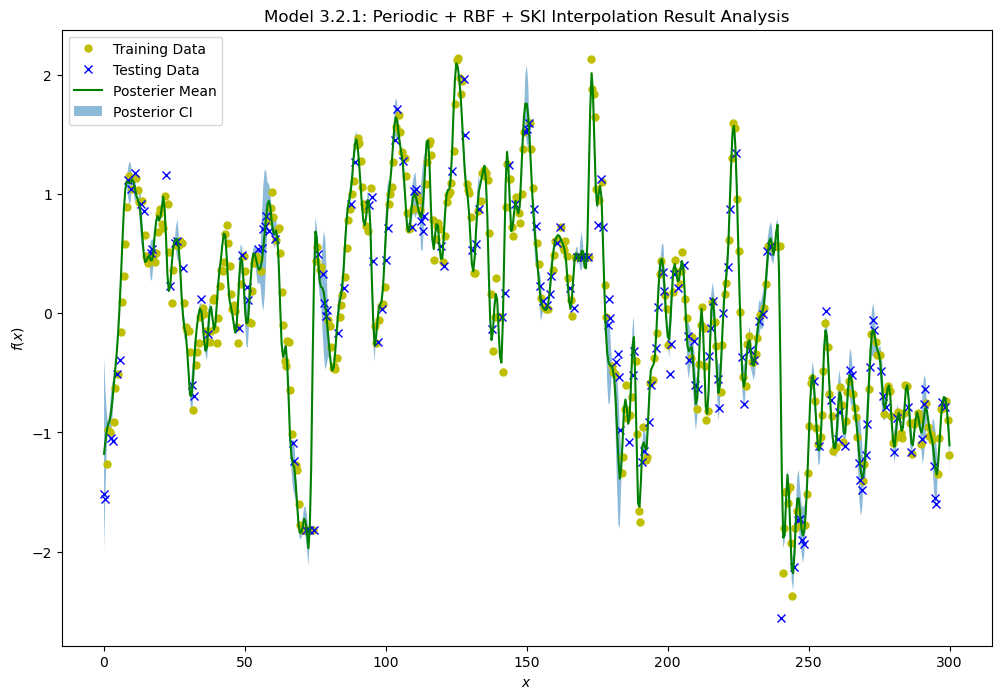

In [110]:
current_experiment_index = [2, 1, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

### Model 3.2.2: Periodic + RBF + SKI + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.089930055544372
tesing MSLL after 300 epochs: 183250209.32522067
training duration for 300 epochs: 43.34443807601929


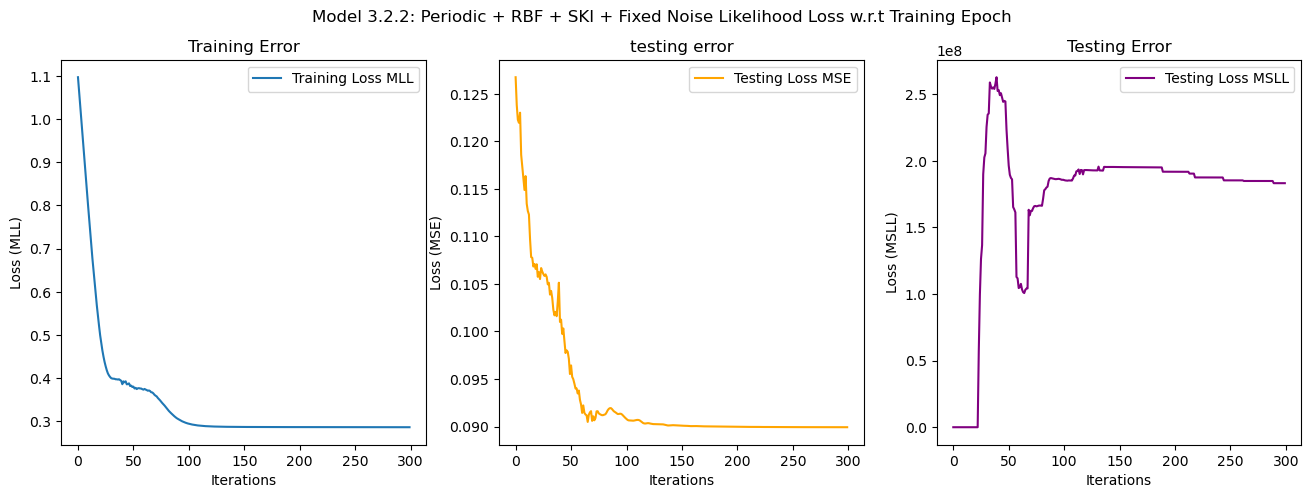

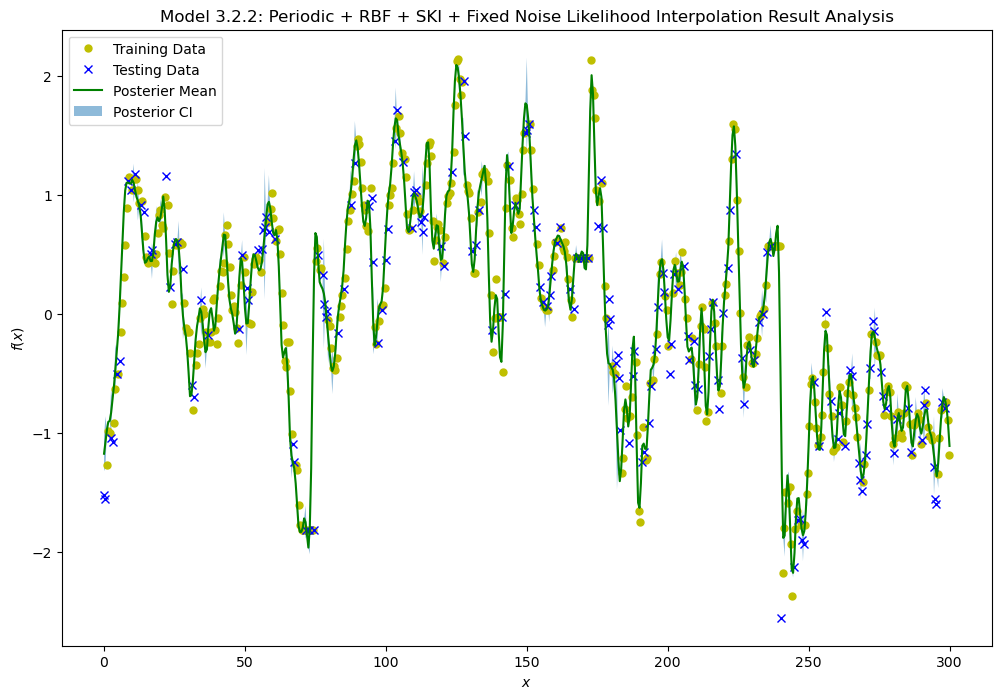

In [111]:
current_experiment_index = [2, 1, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list322, train_losses_mll322 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, experiment_index = current_experiment_index)

## Speed Analysis

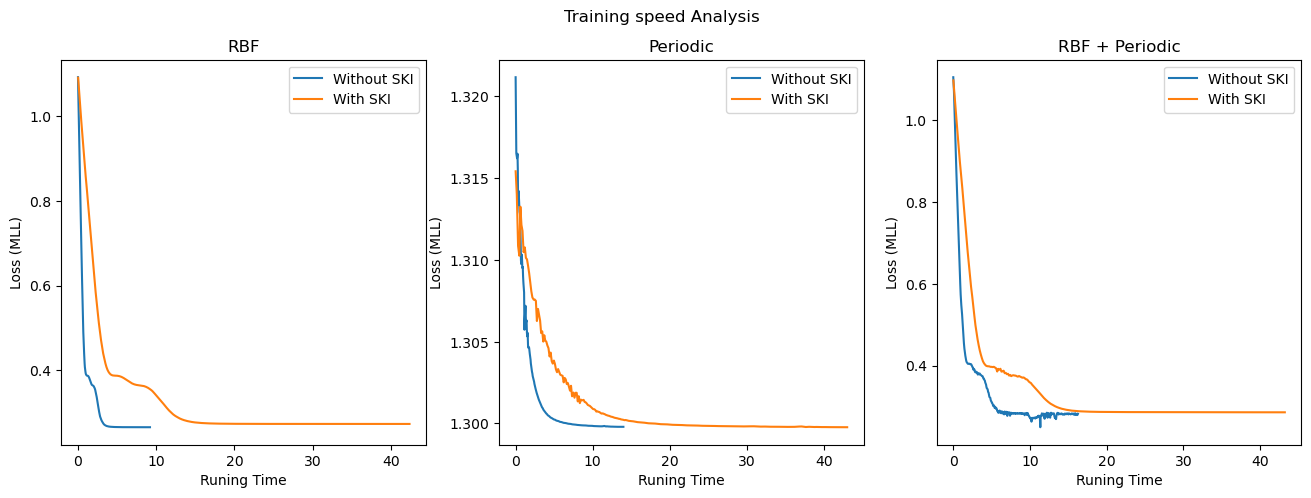

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Training speed Analysis')

axs[0].plot(time_list112, train_losses_mll112, label = 'Without SKI')
axs[0].plot(time_list122, train_losses_mll122, label = 'With SKI')
axs[0].set_xlabel('Runing Time')
axs[0].set_ylabel('Loss (MLL)')
axs[0].set_title('RBF')
axs[0].legend()

axs[1].set_xlabel('Runing Time')
axs[1].set_ylabel('Loss (MLL)')
axs[1].plot(time_list212, train_losses_mll212, label = 'Without SKI')
axs[1].plot(time_list222, train_losses_mll222, label = 'With SKI')
axs[1].set_title('Periodic')
axs[1].legend()

axs[2].set_xlabel('Runing Time')
axs[2].set_ylabel('Loss (MLL)')
axs[2].plot(time_list312, train_losses_mll312, label = 'Without SKI')
axs[2].plot(time_list322, train_losses_mll322, label = 'With SKI')
axs[2].set_title('RBF + Periodic')
axs[2].legend()